In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [2]:

import os
import random
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/transaction-yes-no.zip -d /content/

transaction-yes-no/Yes/❾❻⓿❼⓿❶❽❽❶❺  Wonder Loan Customer care helpline number_9607018815 - Copy.jpg:  mismatching "local" filename (transaction-yes-no/Yes/тЭ╛тЭ╗тУ┐тЭ╝тУ┐тЭ╢тЭ╜тЭ╜тЭ╢тЭ║  Wonder Loan Customer care helpline number_9607018815 - Copy.jpg),
         continuing with "central" filename version
transaction-yes-no/Yes/❾❻⓿❼⓿❶❽❽❶❺  Wonder Loan Customer care helpline number_9607018815.jpg:  mismatching "local" filename (transaction-yes-no/Yes/тЭ╛тЭ╗тУ┐тЭ╝тУ┐тЭ╢тЭ╜тЭ╜тЭ╢тЭ║  Wonder Loan Customer care helpline number_9607018815.jpg),
         continuing with "central" filename version


In [5]:
def initialize_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU")
    except ValueError:
        strategy = tf.distribute.get_strategy()
        print("Running on GPU/CPU")
    return strategy

strategy = initialize_tpu()

Running on GPU/CPU


In [6]:
DATASET_DIR = "/content/transaction-yes-no/"
TRAIN_DIR = "/content/transaction-yes-no/train/"
TEST_DIR = "/content/transaction-yes-no/test/"

In [7]:
MODEL_SAVE_DIR = "/content/saved_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [8]:
for split_dir in [TRAIN_DIR, TEST_DIR]:
    for class_name in ['Yes', 'No']:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

In [9]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

In [10]:
def split_data(source_dir, train_dir, test_dir, train_ratio=0.8):
    for class_name in ['Yes', 'No']:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

split_data(DATASET_DIR, TRAIN_DIR, TEST_DIR, train_ratio=0.8)

In [11]:
def augment_class(class_dir, target_count):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)

    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_format='jpeg'):
            current_count += 1
            if current_count >= target_count:
                break

In [12]:
def undersample_class(class_dir, target_count):
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(images)

    for img_name in images[target_count:]:
        img_path = os.path.join(class_dir, img_name)
        os.remove(img_path)

In [13]:
train_yes_dir = os.path.join(TRAIN_DIR, 'Yes')
train_no_dir = os.path.join(TRAIN_DIR, 'No')

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"Before balancing: Yes = {yes_count}, No = {no_count}")

Before balancing: Yes = 1121, No = 2836


In [14]:
target_count = max(yes_count, no_count)
augment_class(train_yes_dir, target_count)
undersample_class(train_no_dir, target_count)

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"After balancing: Yes = {yes_count}, No = {no_count}")

After balancing: Yes = 2718, No = 2836


In [15]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5554 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [48]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model_mobilenet = MobileNet(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
    base_model_mobilenet.trainable = False  # Freeze the pretrained layers initially

    model_mobilenet = Sequential([
        base_model_mobilenet,
        GlobalAveragePooling2D(),
        Dropout(0.5),  # Increased dropout to reduce overfitting
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),  # Increased dropout
        Dense(1, activation='sigmoid')])

    model_mobilenet.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model_mobilenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,360,705 (12.82 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 3,229,120 (12.32 MB)

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

EPOCHS = 40

In [50]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

mobilenet_model_path = os.path.join(MODEL_SAVE_DIR, 'mobilenet_model.h5')
model_mobilenet.save(mobilenet_model_path)
print(f"mobilenet50 model saved at {mobilenet_model_path}")

Epoch 1/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 209ms/step - accuracy: 0.6785 - loss: 0.8858 - val_accuracy: 0.8063 - val_loss: 0.6161 - learning_rate: 1.0000e-04
Epoch 2/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.8416 - loss: 0.5693 - val_accuracy: 0.8476 - val_loss: 0.5433 - learning_rate: 1.0000e-04
Epoch 3/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.8631 - loss: 0.5224 - val_accuracy: 0.8729 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 4/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - accuracy: 0.8895 - loss: 0.4739 - val_accuracy: 0.8718 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 5/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.8825 - loss: 0.4738 - val_accuracy: 0.8799 - val_loss: 0.4693 - learning_rate: 1.0000e-04
Epoch 6/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.8930 - loss: 0.4509 - val_accuracy: 0.8920 - val_loss: 0.4512 - learning_rate: 1.0000e-04
Epoch 7/40
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 20

mobilenet50 model saved at /content/saved_models/mobilenet_model.h5


In [51]:
from sklearn.metrics import accuracy_score

y_pred_prob_mobilenet = model_mobilenet.predict(test_generator)

y_pred_mobilenet = (y_pred_prob_mobilenet > 0.5).astype('int32')

test_accuracy = accuracy_score(test_generator.classes, y_pred_mobilenet)
print(f"mobilenet Test Accuracy: {test_accuracy:.4f}")

print("\nmobilenet Classification Report:\n", classification_report(test_generator.classes, y_pred_mobilenet))

roc_auc_mobilenet = roc_auc_score(test_generator.classes, y_pred_prob_mobilenet)
print(f"mobilenet ROC-AUC Score: {roc_auc_mobilenet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step
mobilenet Test Accuracy: 0.5681

mobilenet Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       710
           1       0.24      0.25      0.25       281

    accuracy                           0.57       991
   macro avg       0.47      0.47      0.47       991
weighted avg       0.57      0.57      0.57       991

mobilenet ROC-AUC Score: 0.4990


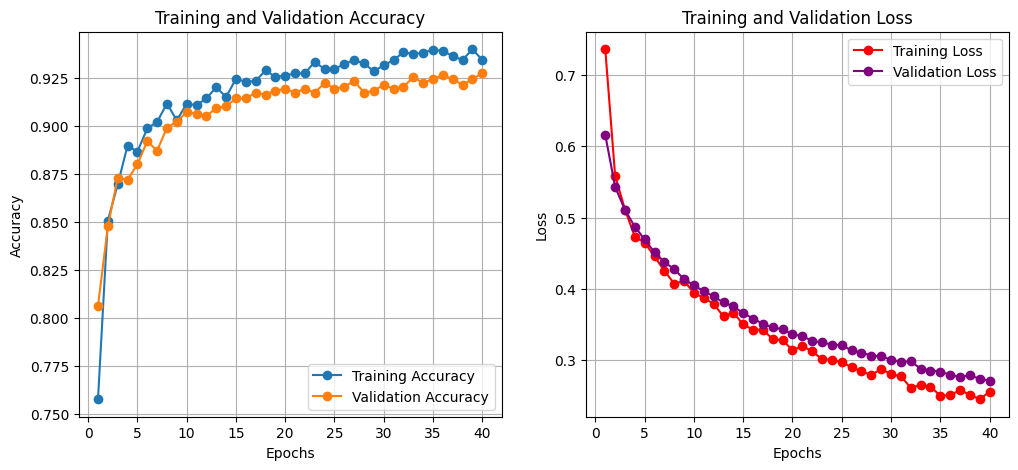

In [52]:
import matplotlib.pyplot as plt

acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.show()


In [53]:
!pip install keras-tuner

In [54]:
model_path = '/content/saved_models/mobilenet_model.h5'
model = load_model(model_path)

def build_model(hp):
    model = load_model(model_path)
    model.trainable = True
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = dropout_rate

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [58]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    directory='hyperparameter_tuning',
    project_name='transaction_classification'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping]
)



Trial 15 Complete [00h 05m 59s]
val_accuracy: 0.931382417678833

Best val_accuracy So Far: 0.940464198589325
Total elapsed time: 02h 01m 10s


In [59]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [60]:
print(f"Best Hyperparameters: {best_hp.values}")

test_accuracy = best_model.evaluate(test_generator)
print(f"Best Model Test Accuracy: {test_accuracy[1]:.4f}")

Best Hyperparameters: {'dropout_rate': 0.25, 'learning_rate': 0.0001038192596156804}
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.9443 - loss: 0.2358
Best Model Test Accuracy: 0.9405


In [61]:
best_model.save('/content/best_mobilenet_model.h5')

In [63]:
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [64]:
import tensorflow as tf
import keras

model = keras.models.load_model("/content/best_mobilenet_model.h5")

tf.saved_model.save(model, "mn_model")

!python3 -m tf2onnx.convert --saved-model mn_model --output best_hp_mobilenet_model.onnx

2025-01-31 18:11:21.984473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738347082.019234   42634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738347082.030022   42634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-31 18:11:35,145 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-01-31 18:11:35.776299: W tensorflow/core/common_